# Set up 

In [1]:
import numpy as np
import os
import sys


# Get the absolute path of the parent directory of the current file (which is 'test')
# current_dir = os.getcwd()
# model_path = os.path.join(current_dir, '..', 'model')
# sys.path.append(model_path)
sys.path.append('..')

from model.Force import HullForce, ControlForce, TowingForce
from model.RigidBody import RigidBody
from model.Simulation import Simulation, Simulation_Result
from model.plotfbd import plotfbd

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
#Set parameters
m = 0.877 # kg
Vol = 733159.45810955 * 10 ** (-9) #m3
Iyy = 6610.17475482 * 10 ** (-6) #kgm2
hull_surface_area = 0.0088 #m2
hull_cd = 1.2
hull_corr_factor = 0.75

r_xi = -111.76 * 10 ** (-3) #m 
r_zi = 0.722 * 10 ** (-3) #m

r_xh = 0
r_zh = 0

r_xb = 0
r_zb = 0

r_xt = 42.9 * 10**(-3)
r_zt = -75 * 10**(-3)

rho = 1000 #kg/m3

# Aero foil parameters
AR = 2.61 #aspect ratio
area = 0.025 #Surface area
C_L_a = 0.1/np.deg2rad(1)
C_L_alpha_offset = 0.5
C_D_0 = 1.328/np.sqrt(200000)

## Initialize the models

In [3]:
rigidbody = RigidBody(m, Vol, Iyy, np.array([r_xb, r_zb]))
towForce = TowingForce(np.array([r_xt,r_zt]),10,np.deg2rad(30))
controlForce = ControlForce(np.array([r_xi,r_zi]),np.deg2rad(-5),AR,area,C_L_a,C_L_alpha_offset,C_D_0)
hullForce = HullForce(hull_surface_area,np.array([r_xh,r_zh]))

sim = Simulation(rigidbody,towForce,hullForce,[controlForce])

# Solve Equilibrium Point

Optimization Results:
----------------------
Parameter       Value           Units     
----------------------
Pitch Angle     -3.68           degrees   
Delta_t         27.05           degrees   
Towing Force    18.62           N         
Delta_i         3.94            degrees   
----------------------
Fx:             0.00           N         
Fz:             -0.00          N         
My:             0.00           Nm        
Residual Norm: 0.000000
Optimization successful!


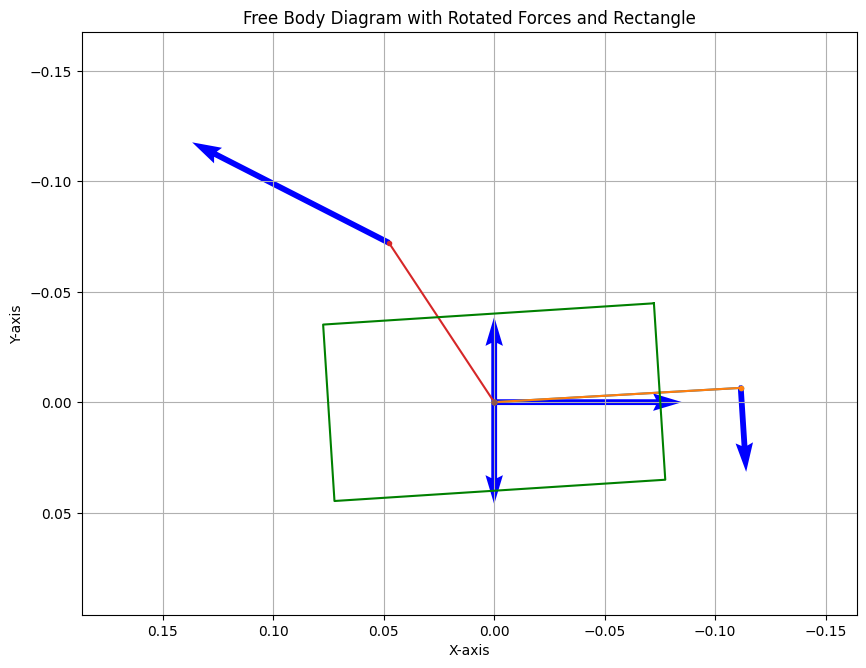

In [4]:
#Find equilibrium by minimizing Forces and moment individually using least squares
results_LS = sim.solve_equilibrium_state_LS(2)

initial_state = np.zeros(9)
initial_state[2] = results_LS[0]
initial_state[3] = 2

plotfbd(sim, sim.eq_sim)


# Equilibrium Simulation

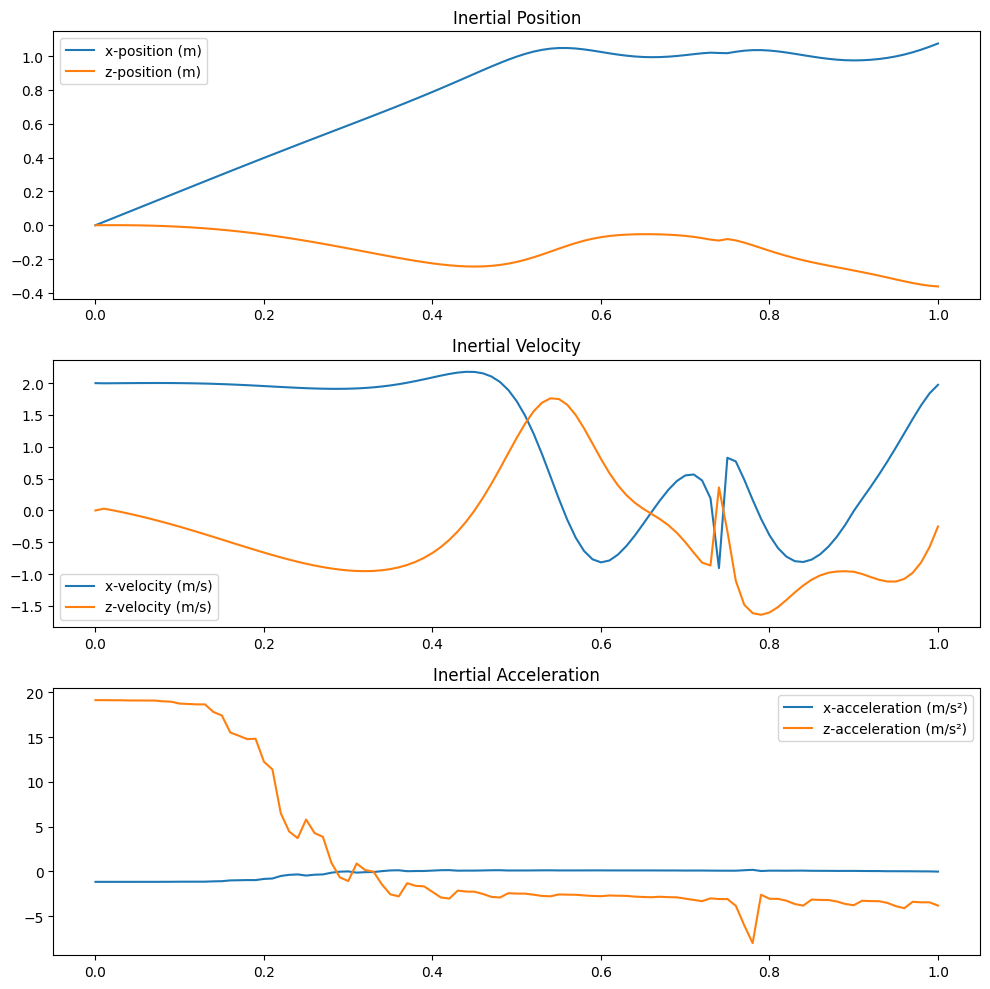

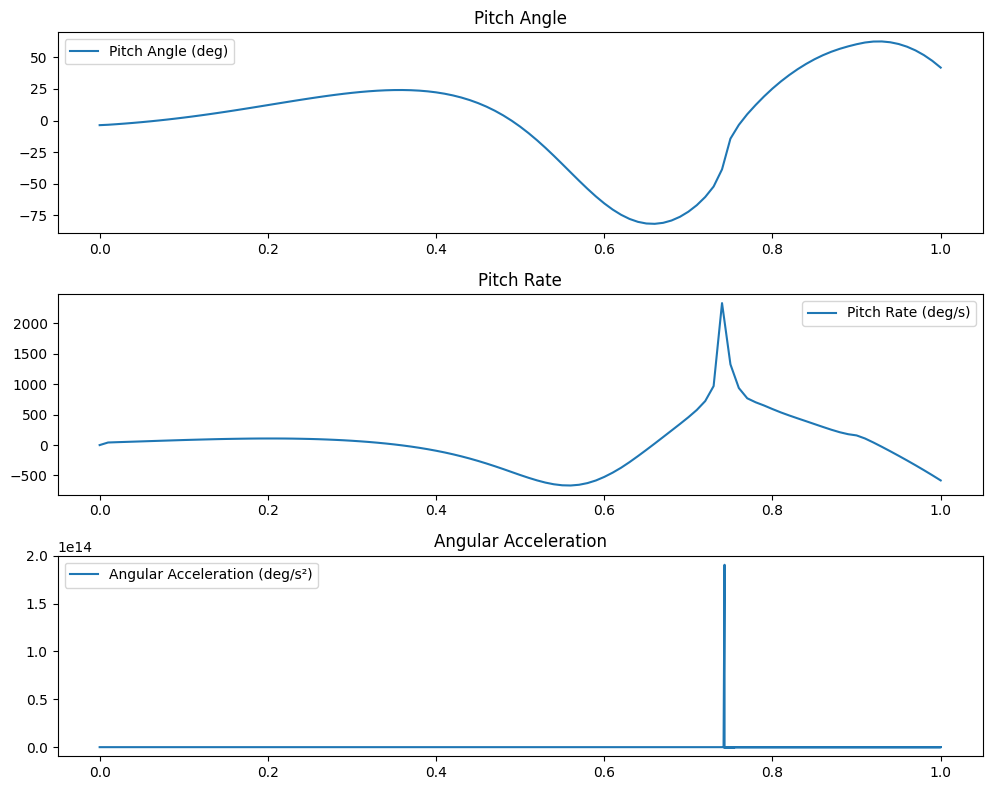

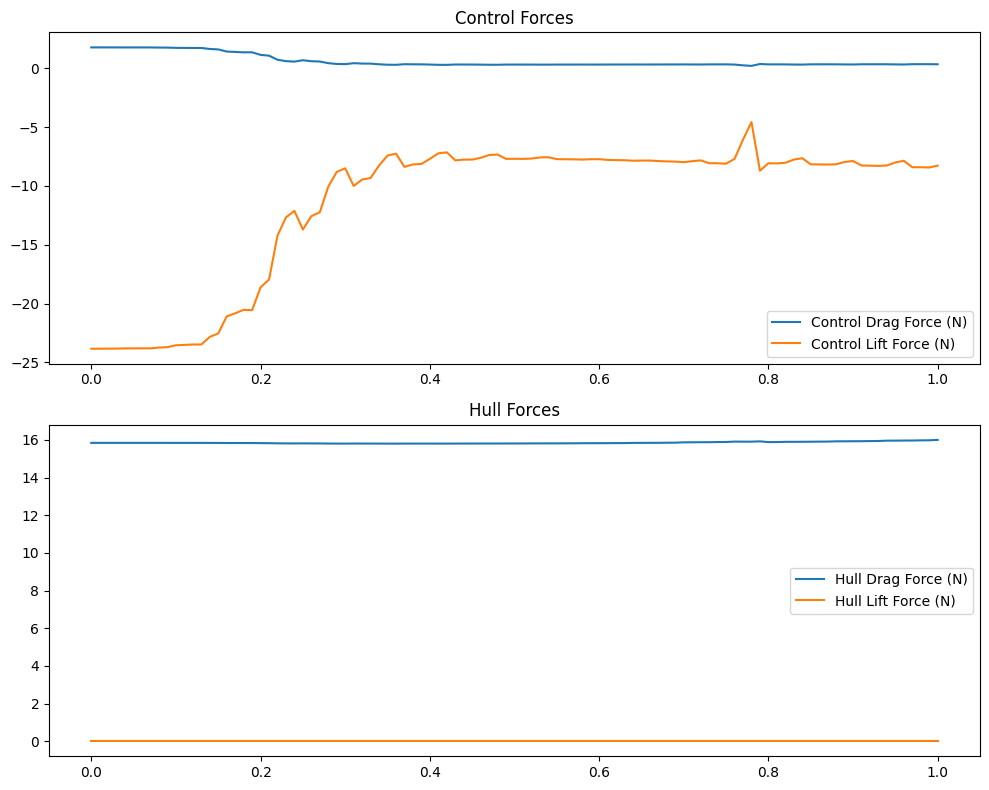

In [5]:
#print(initial_state)
sim_result_ivp, solution = sim.simulate_solve_ivp(100, 0.01, initial_state) ## RK45 Solver
sim_result_ivp.plot_simulation_results()

# Perturbation Simulation

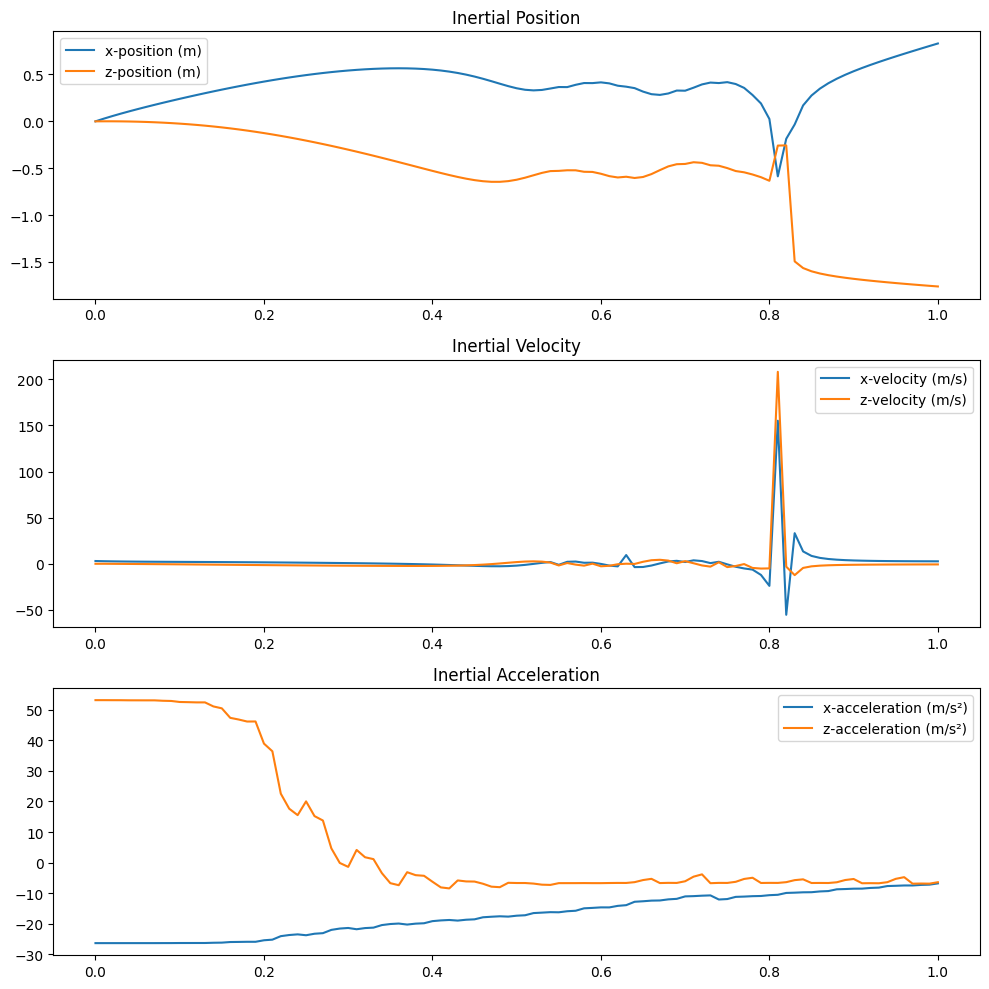

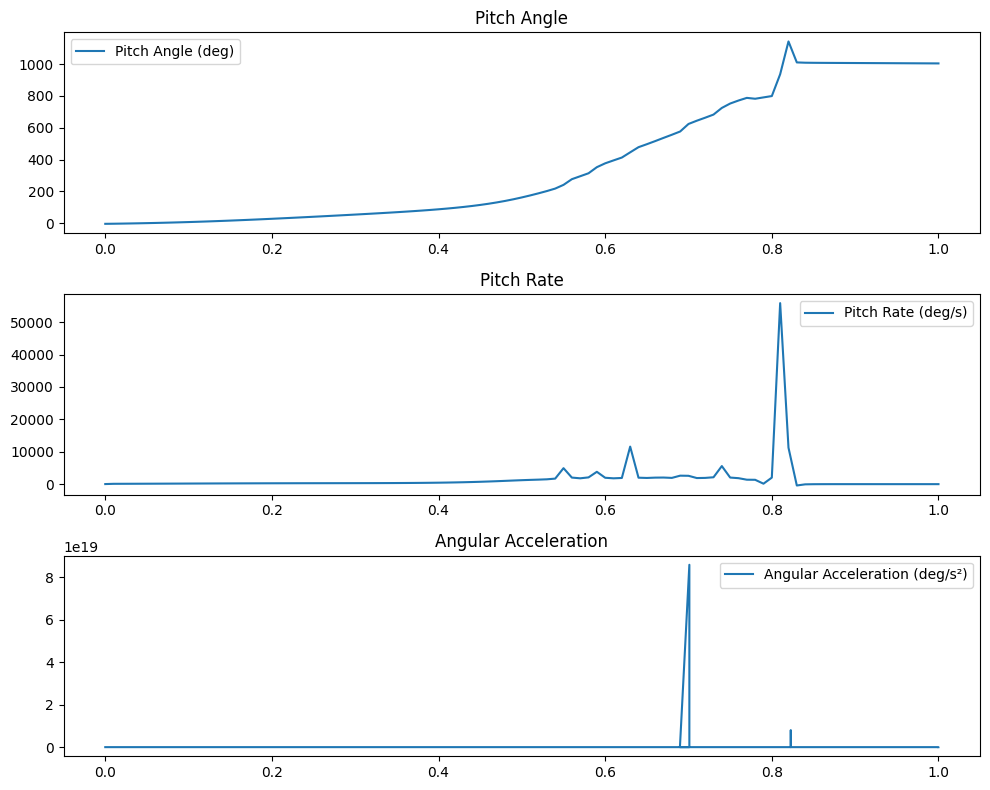

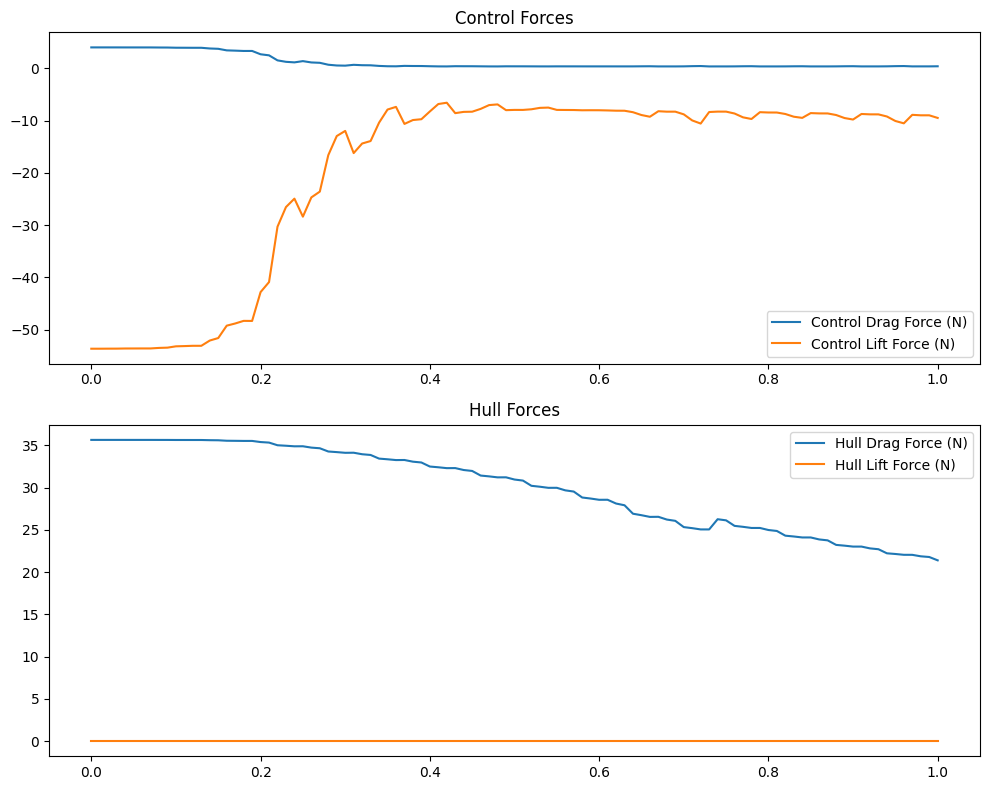

In [6]:
perturbed_state = np.copy(initial_state) 
perturbed_state[3] += 1 #Change Velocity

sim_result_ivp, solution = sim.simulate_solve_ivp(100, 0.01, perturbed_state)
sim_result_ivp.plot_simulation_results()

# Jacobian & Eigenvalues

In [7]:
velocity = 2
pitch_angle = results_LS[0]
jacobian = sim.calculate_jacobian(velocity, pitch_angle, 1e-3)
eigs= np.linalg.eig(jacobian)
print(eigs)

(array([  0.        +0.j        ,   0.        +0.j        ,
       411.81594691+0.j        ,  19.60300699+0.j        ,
        -5.60974671+7.25773361j,  -5.60974671-7.25773361j]), array([[ 1.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
        -7.35218287e-06+0.j        , -4.35631720e-02+0.j        ,
        -6.09853996e-03+0.00991574j, -6.09853996e-03-0.00991574j],
       [ 0.00000000e+00+0.j        ,  1.00000000e+00+0.j        ,
         1.86868365e-04+0.j        , -8.00154947e-03+0.j        ,
        -2.71399236e-03-0.03026892j, -2.71399236e-03+0.03026892j],
       [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
         2.42104997e-03+0.j        , -2.51744804e-02+0.j        ,
         6.32169941e-02+0.08178838j,  6.32169941e-02-0.08178838j],
       [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
         3.02774615e-03+0.j        ,  8.53969165e-01+0.j        ,
         3.77545664e-02+0.09988639j,  3.77545664e-02-0.09988639j],
       [ 0.00000000e+00+